In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.rnn as rnn_utils
import polars as pl
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import Counter
from typing import Dict, List, Tuple

In [2]:
# Constants
BATCH_SIZE = 32
EMB_DIM = 128
HID_DIM = 258
N_LAYERS = 2
N_HEADS = 8
FF_DIM = 512
DROPOUT = 0.1
LEARNING_RATE = 0.001
EPOCHS = 10
FRAC = 0.5

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# Load parquet file
local_path = "../data/output/processed.parquet"
colab_path = "../content/processed.parquet"
kaggle_path= "/kaggle/input/it-en-translation/processed.parquet"
loaded_data = pl.read_parquet(kaggle_path)
print("Data loaded successfully")
loaded_data.head()

Data loaded successfully


it,en
list[str],list[str]
"[""grazie"", ""amico""]","[""thank"", ""buddy""]"
"[""di il""]","[""say""]"
"[""trifosfare"", ""sodio"", … ""sodio""]","[""sodium"", ""triphosphate"", … ""tripolyphosphate""]"
"[""invero"", ""avidare"", … ""ricchezzo""]","[""surely"", ""ardent"", … ""wealth""]"
"[""allegare""]","[""annex""]"


In [5]:
input_data = loaded_data.sample(fraction = FRAC)

input_data.describe()

statistic,it,en
str,f64,f64
"""count""",480021.0,480021.0
"""null_count""",0.0,0.0
"""mean""",null,null
"""std""",null,null
"""min""",null,null
"""25%""",null,null
"""50%""",null,null
"""75%""",null,null
"""max""",null,null


In [6]:
from collections import defaultdict

def build_vocab(tokens):
    vocab = defaultdict(lambda: len(vocab))  # Assign unique indices
    vocab["<pad>"]  # Reserve 0 for padding
    for token_list in tokens:
        for token in token_list:
            _ = vocab[token]
    return dict(vocab)

def preprocess_data(df):
    it_vocab = build_vocab(df["it"])
    en_vocab = build_vocab(df["en"])
    
    it_indices = [
        torch.tensor([it_vocab[token] for token in tokens], dtype=torch.long)
        for tokens in df["it"]
    ]
    en_indices = [
        torch.tensor([en_vocab[token] for token in tokens], dtype=torch.long)
        for tokens in df["en"]
    ]
    return list(zip(en_indices, it_indices)), len(it_vocab), len(en_vocab)

In [7]:
data_pairs, IT_VOCAB_SIZE, EN_VOCAB_SIZE = preprocess_data(input_data)

In [8]:
print(f"Italian Vocabulary Size: {IT_VOCAB_SIZE}")
print(f"English Vocabulary Size: {EN_VOCAB_SIZE}")

Italian Vocabulary Size: 133927
English Vocabulary Size: 87719


In [9]:
class TranslationDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        return self.pairs[idx]

In [10]:
def collate_fn(batch):
    src = [pair[0] for pair in batch]
    trg = [pair[1] for pair in batch]
    src_padded = nn.utils.rnn.pad_sequence(src, batch_first=True, padding_value=0)
    trg_padded = nn.utils.rnn.pad_sequence(trg, batch_first=True, padding_value=0)
    return src_padded, trg_padded

In [11]:
train_loader = DataLoader(
    TranslationDataset(data_pairs),
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn
)

In [12]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, trg_vocab_size, emb_dim, n_heads, ff_dim, n_layers, dropout):
        super().__init__()
        # Ensure src_vocab_size matches the vocabulary size from preprocessing
        self.src_embedding = nn.Embedding(src_vocab_size, emb_dim)
        # Ensure trg_vocab_size matches the vocabulary size from preprocessing
        self.trg_embedding = nn.Embedding(trg_vocab_size, emb_dim)
        # Check that the positional encoding length covers all sequence lengths
        self.positional_encoding = self._get_positional_encoding(emb_dim)

        self.transformer = nn.Transformer(
            d_model=emb_dim,
            nhead=n_heads,
            num_encoder_layers=n_layers,
            num_decoder_layers=n_layers,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True
        )
        self.fc_out = nn.Linear(emb_dim, trg_vocab_size)

    def forward(self, src, trg):
        src_seq_len = src.size(1)  # Sequence length of source
        src = self.src_embedding(src) + self.positional_encoding[:, :src_seq_len, :].to(src.device)
        trg_seq_len = trg.size(1)  # Sequence length of target
        trg = self.trg_embedding(trg) + self.positional_encoding[:, :trg_seq_len, :].to(trg.device)

        src_mask = self._generate_square_subsequent_mask(src_seq_len).to(src.device)
        trg_mask = self._generate_square_subsequent_mask(trg_seq_len).to(trg.device)
        memory_mask = None

        # Ensure src, trg, and masks are aligned
        output = self.transformer(
            src, trg, src_mask=src_mask, tgt_mask=trg_mask, memory_mask=memory_mask
        )
        output = self.fc_out(output)

        return output

    def _generate_square_subsequent_mask(self, sz):
        return torch.triu(torch.full((sz, sz), float('-inf')), diagonal=1)

    def _get_positional_encoding(self, emb_dim, max_len=5000):
        pe = torch.zeros(1, max_len, emb_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_dim, 2).float() * -(torch.log(torch.tensor(10000.0)) / emb_dim))
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        return pe

In [13]:
model = Transformer(EN_VOCAB_SIZE, IT_VOCAB_SIZE, EMB_DIM, N_HEADS, FF_DIM, N_LAYERS, DROPOUT).to(device)

In [14]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [15]:
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0

    for src, trg in iterator:
        src = src.to(device, non_blocking=True)
        trg = trg.to(device, non_blocking=True)
        trg_input = trg[:, :-1]
        trg_output = trg[:, 1:]

        optimizer.zero_grad()

        output = model(src, trg_input)
        output_dim = output.shape[-1]

        output = output.reshape(-1, output_dim)
        trg_output = trg_output.reshape(-1)

        loss = criterion(output, trg_output)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [16]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for src, trg in iterator:
            src = src.to(device, non_blocking=True)
            trg = trg.to(device, non_blocking=True)
            trg_input = trg[:, :-1]
            trg_output = trg[:, 1:]

            output = model(src, trg_input)
            output_dim = output.shape[-1]

            output = output.reshape(-1, output_dim)
            trg_output = trg_output.reshape(-1)

            loss = criterion(output, trg_output)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [17]:
train_losses, eval_losses = [], []

for epoch in range(EPOCHS):
    train_loss = train(model, train_loader, optimizer, criterion)
    eval_loss = evaluate(model, train_loader, criterion)

    train_losses.append(train_loss)
    eval_losses.append(eval_loss)

    print(f"Epoch {epoch + 1}/{EPOCHS} - Train Loss: {train_loss:.4f} | Eval Loss: {eval_loss:.4f}")

Epoch 1/10 - Train Loss: 7.9368 | Eval Loss: 7.2821
Epoch 2/10 - Train Loss: 7.2229 | Eval Loss: 6.7190
Epoch 3/10 - Train Loss: 6.8127 | Eval Loss: 6.2839
Epoch 4/10 - Train Loss: 6.5263 | Eval Loss: 5.9653
Epoch 5/10 - Train Loss: 6.3163 | Eval Loss: 5.7348
Epoch 6/10 - Train Loss: 6.1437 | Eval Loss: 5.5074
Epoch 7/10 - Train Loss: 5.9978 | Eval Loss: 5.3026
Epoch 8/10 - Train Loss: 5.8758 | Eval Loss: 5.1395
Epoch 9/10 - Train Loss: 5.7665 | Eval Loss: 4.9943
Epoch 10/10 - Train Loss: 5.6741 | Eval Loss: 4.8410


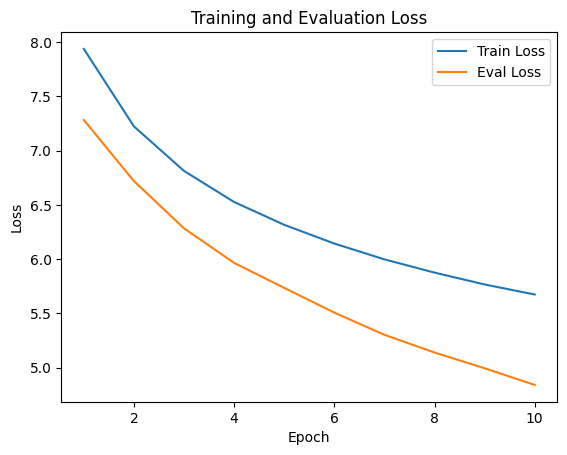

In [18]:
plt.plot(range(1, EPOCHS + 1), train_losses, label="Train Loss")
plt.plot(range(1, EPOCHS + 1), eval_losses, label="Eval Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Evaluation Loss")
plt.show()

In [19]:
torch.save(model.state_dict(), "/kaggle/working/transformer_translation_model.pth")